# Transform and split DWPCs, assess performance

In [1]:
import itertools
import bz2

import pandas
import numpy
import sklearn.metrics
from scipy.special import logit

In [2]:
unperm_name = 'wikidata-v0.1'

In [3]:
feature_df = pandas.read_table('data/matrix/features.tsv.bz2')
feature_type_df = pandas.read_table('data/matrix/feature-type.tsv')

In [4]:
feature_df.head(2)

,hetnet,compound_id,disease_id,status,primary,disease_name,compound_name,prior_prob,CduftD,CpiwP,...,CsdiCpiwPeGgaD,CsdiCpiwPpiwCduftD,CsdiCsdiC<hpCduftD,CsdiCsdiC<ioCduftD,CsdiCsdiCduftD,CsdiCsdiCduftD<soD,CsdiCsdiCduftDso>D,CsdiCsdiChp>CduftD,CsdiCsdiCio>CduftD,CsdiCsdiCsdiCduftD
0,wikidata-v0.1_perm-1,Q10354103,Q1048084,1,1,opisthorchiasis,probucol,0.001998,3,1,...,0,0,0,0,0.010103,0,0,0,0,0.014973
1,wikidata-v0.1_perm-5,Q118551,Q1048084,1,1,opisthorchiasis,clarithromycin,0.006174,9,0,...,0,0,0,0,0.000000,0,0,0,0,0.000000


In [5]:
feature_type_df.head(2)

,feature,feature_type,unperm_mean,unperm_sd
0,prior_prob,prior,0.008933,0.020257
1,CduftD,degree,3.366700,3.191600


In [6]:
def transform_dwpcs(x, scaler):
    x = numpy.array(x)
    return numpy.arcsinh(x / scaler)

transformed_df = feature_df.copy()
dwpc_features = feature_type_df.query("feature_type == 'dwpc'").feature
degree_features = feature_type_df.query("feature_type == 'degree'").feature
feature_to_scaler = dict(zip(feature_type_df.feature, feature_type_df.unperm_mean))
for column in dwpc_features:
    transformed_df[column] = transform_dwpcs(transformed_df[column], feature_to_scaler[column])

In [38]:
column_names = list()
columns = list()
for metapath in dwpc_features:
    df = pandas.pivot_table(transformed_df, values=metapath, index=['compound_id', 'disease_id'], columns='hetnet')
    df = df[df[unperm_name].notnull()]
    dwpc = df.iloc[:, 0]
    pdwpc = df.iloc[:, 1:].mean(axis='columns')
    rdwpc = dwpc - pdwpc
    for column in dwpc, pdwpc, rdwpc:
        columns.append(column)
    for feature_type in 'dwpc', 'pdwpc', 'rdwpc':
        column_names.append('{}_{}'.format(feature_type, metapath))

split_df = pandas.concat(columns, levels=column_names, axis=1)
split_df.columns = column_names
split_df.reset_index(inplace=True)

In [39]:
split_df.head(2)

,compound_id,disease_id,dwpc_C<hpC<hpC<hpCduftD,pdwpc_C<hpC<hpC<hpCduftD,rdwpc_C<hpC<hpC<hpCduftD,dwpc_C<hpC<hpC<ioCduftD,pdwpc_C<hpC<hpC<ioCduftD,rdwpc_C<hpC<hpC<ioCduftD,dwpc_C<hpC<hpCduftD,pdwpc_C<hpC<hpCduftD,...,rdwpc_CsdiCsdiCduftDso>D,dwpc_CsdiCsdiChp>CduftD,pdwpc_CsdiCsdiChp>CduftD,rdwpc_CsdiCsdiChp>CduftD,dwpc_CsdiCsdiCio>CduftD,pdwpc_CsdiCsdiCio>CduftD,rdwpc_CsdiCsdiCio>CduftD,dwpc_CsdiCsdiCsdiCduftD,pdwpc_CsdiCsdiCsdiCduftD,rdwpc_CsdiCsdiCsdiCduftD
0,Q10354103,Q1435822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.727271,0,0,0,NaN,NaN,NaN,1.253471,2.431816,-1.178345
1,Q10354103,Q177190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.066166,0,0,0,NaN,NaN,NaN,0.000000,1.704287,-1.704287


In [40]:
base_df = feature_df.query("hetnet == @unperm_name").copy()
base_df.insert(8, 'prior_logit', logit(base_df['prior_prob']))
for metaege in degree_features:
    base_df['degree_{}'.format(metaege)] = numpy.arcsinh(base_df[metaege])
base_df.drop(
    ['hetnet', 'primary', 'prior_prob'] + list(degree_features) + list(dwpc_features),
    axis='columns', inplace=True)
transformed_df = base_df.merge(split_df)
transformed_df.head(2)

,compound_id,disease_id,status,disease_name,compound_name,prior_logit,degree_CduftD,degree_CpiwP,degree_CsdiC,degree_C<hpC,...,rdwpc_CsdiCsdiCduftDso>D,dwpc_CsdiCsdiChp>CduftD,pdwpc_CsdiCsdiChp>CduftD,rdwpc_CsdiCsdiChp>CduftD,dwpc_CsdiCsdiCio>CduftD,pdwpc_CsdiCsdiCio>CduftD,rdwpc_CsdiCsdiCio>CduftD,dwpc_CsdiCsdiCsdiCduftD,pdwpc_CsdiCsdiCsdiCduftD,rdwpc_CsdiCsdiCsdiCduftD
0,Q144085,Q1048084,0,opisthorchiasis,pimozide,-5.691494,2.312438,2.644121,4.304248,0,...,0,0,0,0,NaN,NaN,NaN,0,1.786412,-1.786412
1,Q20817199,Q1048084,0,opisthorchiasis,Ephedra,-6.624488,1.443635,0.000000,0.000000,0,...,0,0,0,0,NaN,NaN,NaN,0,0.000000,0.000000


In [41]:
path = 'data/matrix/wikidata-v0.1/transformed-features.tsv.bz2'
with bz2.open(path, 'wt') as write_file:
    transformed_df.to_csv(write_file, sep='\t', index=False, float_format='%.5g')

### Compute performance

In [43]:
transformed_df = transformed_df.dropna(axis=1)
transformed_df.head(2)

,compound_id,disease_id,status,disease_name,compound_name,prior_logit,degree_CduftD,degree_CpiwP,degree_CsdiC,degree_C<hpC,...,rdwpc_CsdiCsdiCduftD<soD,dwpc_CsdiCsdiCduftDso>D,pdwpc_CsdiCsdiCduftDso>D,rdwpc_CsdiCsdiCduftDso>D,dwpc_CsdiCsdiChp>CduftD,pdwpc_CsdiCsdiChp>CduftD,rdwpc_CsdiCsdiChp>CduftD,dwpc_CsdiCsdiCsdiCduftD,pdwpc_CsdiCsdiCsdiCduftD,rdwpc_CsdiCsdiCsdiCduftD
0,Q144085,Q1048084,0,opisthorchiasis,pimozide,-5.691494,2.312438,2.644121,4.304248,0,...,-0.757375,0,0,0,0,0,0,0,1.786412,-1.786412
1,Q20817199,Q1048084,0,opisthorchiasis,Ephedra,-6.624488,1.443635,0.000000,0.000000,0,...,0.000000,0,0,0,0,0,0,0,0.000000,0.000000


In [44]:
rows  = list()
for column in transformed_df.columns[transformed_df.columns.str.contains('dwpc')]:
    feature_type, metapath = column.split('_', 1)
    auroc = sklearn.metrics.roc_auc_score(transformed_df.status, transformed_df[column])
    rows.append([feature_type + '_auroc', metapath, auroc])
auroc_df = pandas.DataFrame(rows, columns=['feature_type', 'metapath', 'auroc'])
auroc_df = auroc_df.pivot_table(values='auroc', index='metapath', columns='feature_type').reset_index()
auroc_df.head(2)

feature_type,metapath,dwpc_auroc,pdwpc_auroc,rdwpc_auroc
0,C<hpCduftD,0.500337,0.499958,0.500379
1,C<hpCduftDduftCduftD,0.500295,0.500000,0.500295


In [45]:
primary_auroc_df = pandas.read_table('data/feature-performance/primary-aurocs.tsv')
primary_auroc_df = primary_auroc_df.rename(columns={'feature': 'metapath', 'auroc_permuted': 'pdwpc_primary_auroc', 'pval_auroc': 'pval_delta_auroc'})
primary_auroc_df = primary_auroc_df[['metapath', 'nonzero', 'pdwpc_primary_auroc', 'delta_auroc', 'pval_delta_auroc']]
auroc_df = auroc_df.merge(primary_auroc_df)
auroc_df.head(2)

feature_type,metapath,dwpc_auroc,pdwpc_auroc,rdwpc_auroc,nonzero,pdwpc_primary_auroc,delta_auroc,pval_delta_auroc
0,C<hpCduftD,0.500337,0.499958,0.500379,0.000135,0.50000,0.000341,9.261700e-08
1,C<hpCduftDduftCduftD,0.500295,0.500000,0.500295,0.000202,0.50002,0.000273,2.113100e-04


In [46]:
auroc_df.to_csv('data/feature-performance/auroc.tsv', sep='\t', index=False, float_format='%.5g')

In [56]:
#auroc_df.sort_values('rdwpc_auroc', ascending = False)
idx = -auroc_df.metapath.str.contains('CduftD') & ~auroc_df.metapath.str.contains('DduftC')
auroc_df[idx].sort_values('rdwpc_auroc', ascending = False).head()

feature_type,metapath,dwpc_auroc,pdwpc_auroc,rdwpc_auroc,nonzero,pdwpc_primary_auroc,delta_auroc,pval_delta_auroc
41,CpiwPeGgaDso>D,0.500758,0.500126,0.500632,0.000472,0.49999,0.000769,8.033300e-09
39,CpiwPeGgaD,0.500884,0.500253,0.500589,0.000606,0.50004,0.000844,6.544400e-05
40,CpiwPeGgaD<soD,0.500126,0.499832,0.500295,0.000135,0.50004,0.000086,1.036200e-01
62,CsdiCpiwPeGgaD,0.500379,0.501769,0.498862,0.000404,0.50023,0.000147,2.709100e-01


## Visualization Sandbox

In [57]:
%matplotlib inline
import seaborn

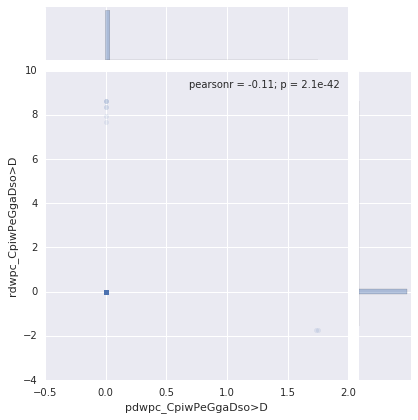

In [58]:
seaborn.jointplot(transformed_df['pdwpc_CpiwPeGgaDso>D'], transformed_df['rdwpc_CpiwPeGgaDso>D'], alpha = 0.1);

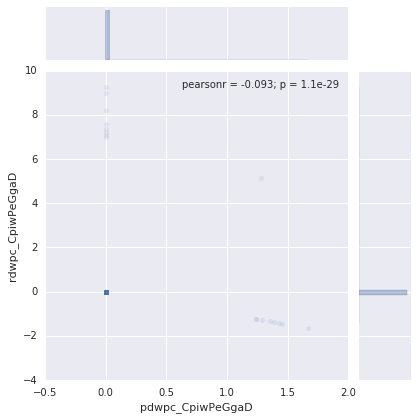

In [59]:
seaborn.jointplot(transformed_df['pdwpc_CpiwPeGgaD'], transformed_df['rdwpc_CpiwPeGgaD'], alpha = 0.1);

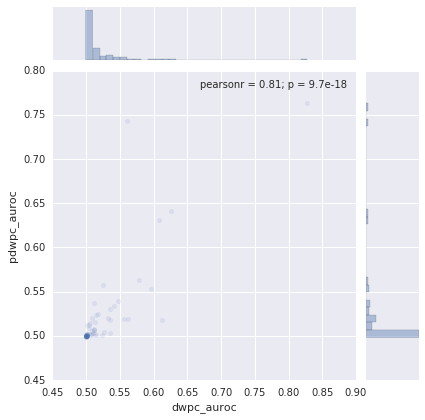

In [60]:
seaborn.jointplot(auroc_df['dwpc_auroc'], auroc_df['pdwpc_auroc'], alpha = 0.1);

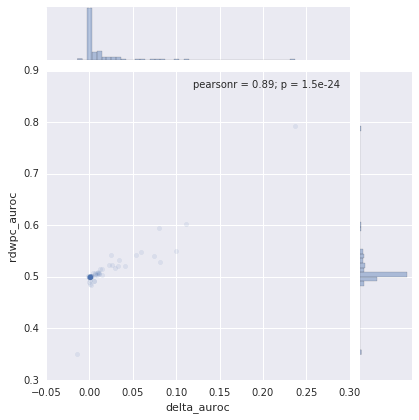

In [61]:
seaborn.jointplot(auroc_df['delta_auroc'], auroc_df['rdwpc_auroc'], alpha = 0.1);